#HW6, Michał Szumielewicz

#Setup

I use the brain_stroke dataset from https://www.kaggle.com/datasets/jillanisofttech/brain-stroke-dataset (the second one with more features)

#Models

I use the sklearn RandomForestClassifier as the first model

I use GradientBoostingClassifier, AdaBoostClassifier and XGBoost as the other models

#Permutation based variable importance for Random Forest




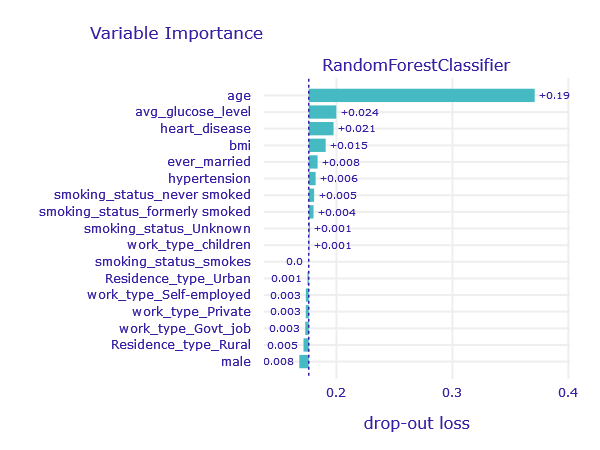

Age here is clearly the most important variable, other somewhat important are glucose level, whether the person suffered through a heart disease and their bmi. Almost all of the variables influence the model's decisions.

A very interesting case here is that a few variables negatively impact the model's accuracy. Their impact is really small but noticeable with PVI.

#PVI for other models

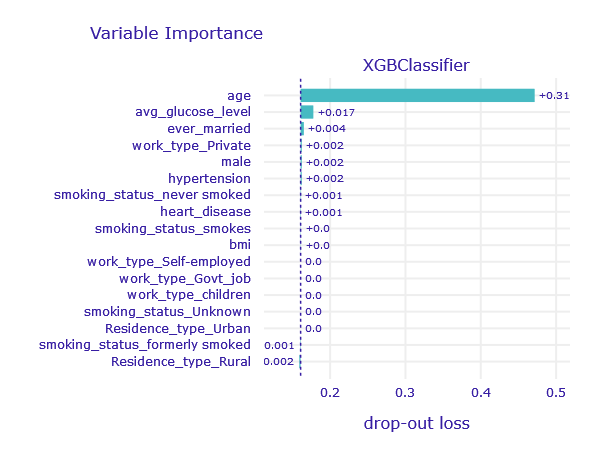

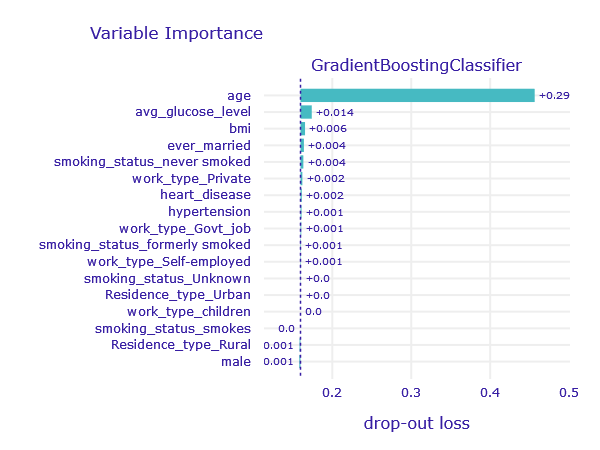

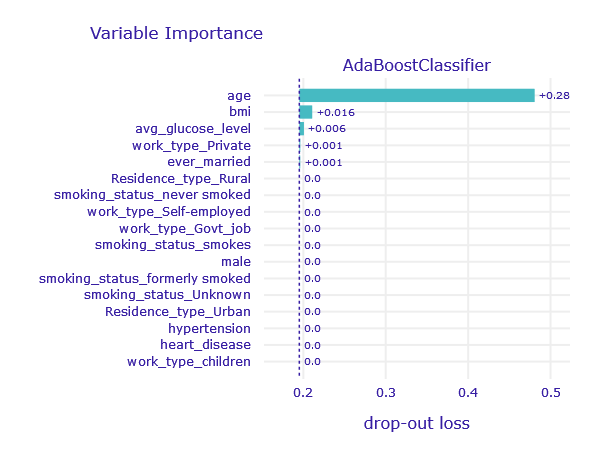

PVI for other models reiterates that age is by far the most important factor when predicting for brain stroke (at least according to the models) and to some extent glucose level and bmi. Other factors play a role when deciding, albeit a really small one.

What is very important in that is that the other models place almost no emphasis on the categorical variables in the data, especially compared to the random forest model.

After checking it turns out the first model has in fact the lowest accuracy on the test dataset of the 4 models. It is almost certainly caused by overfitting coupled with a very imbalanced dataset with noisy data, about 95% of the cases are negative and that is approximately the accuracy of all the models.

It must be noted that even on the positive cases it did not perform better than the GB classifier.

PVI can therefore highlight a case of a variable being seemingly useless or even detrimental (with bad luck) for the prediction


#Comparison

Feature importance according to the Random Forest model:

[('avg_glucose_level', 0.2609035417381537),
 ('age', 0.24017263477625822),
 ('bmi', 0.2292150621143247),
 ('male', 0.03263121942418471),
 ('hypertension', 0.026877127645745565),
 ('work_type_Private', 0.02169482048799827),
 ('smoking_status_never smoked', 0.021609879219989626),
 ('Residence_type_Rural', 0.020518963625785435),
 ('smoking_status_formerly smoked', 0.020516187967612037),
 ('work_type_Self-employed', 0.020186206946750596),
 ('heart_disease', 0.01971886102394669),
 ('Residence_type_Urban', 0.019594811288031703),
 ('ever_married', 0.018466490061457726),
 ('smoking_status_Unknown', 0.017984566867333546),
 ('smoking_status_smokes', 0.016978299379746663),
 ('work_type_Govt_job', 0.011730533834754777),
 ('work_type_children', 0.0012007935979260705)]

The numerical features are the top 3 by a wide margin, this is however due to them being numberical. Interestingly, glucose level seems to be more important here than age, which is somewhat bad for the model as it is not the most important feature according to PVI.

After checking, all of the other models consider age the most important feature (rightfully so).

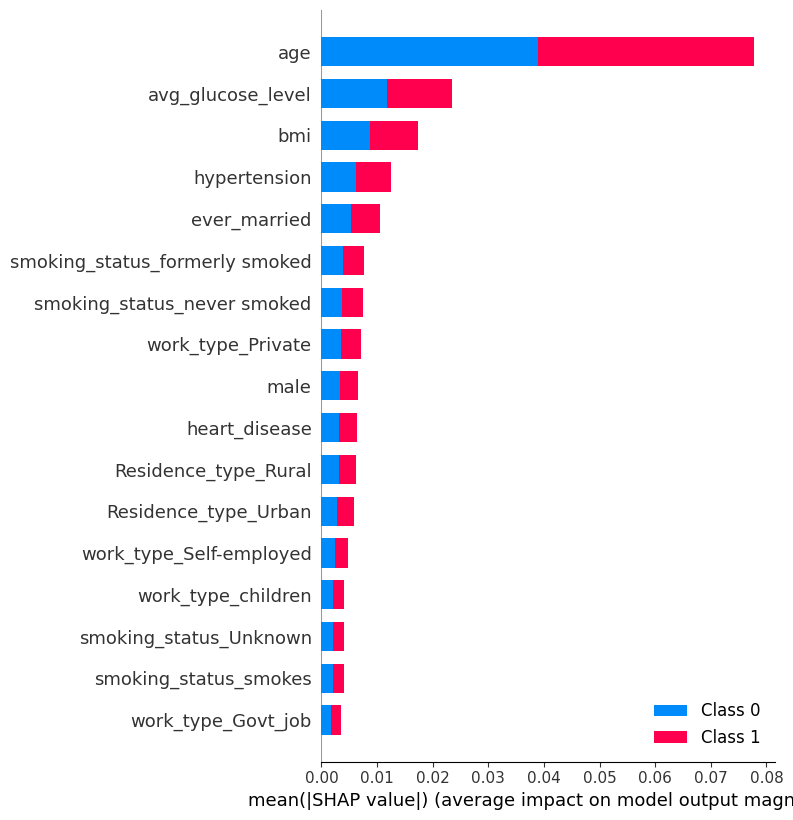

Shapley values are somewhat consistent with PVI values, again bmi is a bit more important but the general trends are the same.

#Appendix, Michał Szumielewicz

#Data setup

In [2]:
import pandas as pd
df = pd.read_csv('brain_stroke.csv')

df["ever_married"] = (df["ever_married"] == "Yes")
df["male"] = (df["gender"] == "Male")
df = df.drop(["gender"], axis=1)
for col in ["work_type", "Residence_type","smoking_status"]:


  one_hots = pd.get_dummies(df[col], prefix=col)
  df = pd.concat([df, one_hots], axis=1)
  df = df.drop([col], axis=1)

X = df.drop(['stroke'], axis=1)
y = df['stroke']

In [3]:
X.head()

,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,male,work_type_Govt_job,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,True,228.69,36.6,True,0,1,0,0,0,1,0,1,0,0
1,80.0,0,1,True,105.92,32.5,True,0,1,0,0,1,0,0,0,1,0
2,49.0,0,0,True,171.23,34.4,False,0,1,0,0,0,1,0,0,0,1
3,79.0,1,0,True,174.12,24.0,False,0,0,1,0,1,0,0,0,1,0
4,81.0,0,0,True,186.21,29.0,True,0,1,0,0,0,1,0,1,0,0


In [4]:
y.value_counts()

0    4733
1     248
Name: stroke, dtype: int64

#Models and PVI

In [19]:
import xgboost
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
import sklearn

xgbmodel = xgboost.XGBClassifier(
    n_estimators=50,
    max_depth=2,
    use_label_encoder=False,
    eval_metric="logloss",

    enable_categorical=True,
    tree_method="hist"
)

rfmodel = RandomForestClassifier()

gbmodel = GradientBoostingClassifier()

abmodel = AdaBoostClassifier()



RandomForestClassifier()

In [20]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.33, random_state=42)

In [21]:
xgbmodel.fit(X_train, y_train)
rfmodel.fit(X_train, y_train)
gbmodel.fit(X_train, y_train)
abmodel.fit(X_train, y_train)

AdaBoostClassifier()

In [7]:
!pip install dalex
import dalex as dx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for dalex: filename=dalex-1.6.0-py3-none-any.whl size=1045993 sha256=0a87d81666236d22ecbe430dac1f92822c2567240deeb9463c73c298d0c4ab00
  Stored in directory: /root/.cache/pip/wheels/c8/45/19/f5810bf7c5ff9a476ebd89bb5b81a18ffcdf93931d17dbb0c1
Successfully built dalex


In [27]:
explainer = dx.Explainer(rfmodel, X_test, y_test)

Preparation of a new explainer is initiated

  -> data              : 1644 rows 17 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 1644 values
  -> model_class       : sklearn.ensemble._forest.RandomForestClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x7edb33f5b0a0> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0, mean = 0.0509, max = 0.67
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.67, mean = 0.000766, max = 1.0
  -> model_info        : package sklearn

A new explainer has been created!


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



In [50]:
explainer.model_performance()

,recall,precision,f1,accuracy,auc
RandomForestClassifier,0.023529,0.25,0.043011,0.945864,0.82076


In [29]:
pvi = explainer.model_parts(random_state=0)
pvi.result

,variable,dropout_loss,label
0,male,0.167955,RandomForestClassifier
1,Residence_type_Rural,0.171554,RandomForestClassifier
2,work_type_Govt_job,0.173076,RandomForestClassifier
3,work_type_Private,0.173525,RandomForestClassifier
4,work_type_Self-employed,0.173587,RandomForestClassifier
5,Residence_type_Urban,0.174973,RandomForestClassifier
6,smoking_status_smokes,0.175963,RandomForestClassifier
7,_full_model_,0.176100,RandomForestClassifier
8,work_type_children,0.176622,RandomForestClassifier
9,smoking_status_Unknown,0.177036,RandomForestClassifier


In [46]:
pvi.plot(max_vars=20, show=False).update_layout(autosize=False, width=600, height=450)

In [47]:
dx.Explainer(xgbmodel, X_test, y_test).model_parts(random_state=0).plot(max_vars=20,show=False).update_layout(autosize=False, width=600, height=450)

Preparation of a new explainer is initiated

  -> data              : 1644 rows 17 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 1644 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x7edb33f5b0a0> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.000127, mean = 0.0469, max = 0.551
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.551, mean = 0.00477, max = 0.999
  -> model_info        : package xgboost

A new explainer has been created!


In [34]:
dx.Explainer(xgbmodel, X_test, y_test).model_performance()

Preparation of a new explainer is initiated

  -> data              : 1644 rows 17 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 1644 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x7edb33f5b0a0> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.000127, mean = 0.0469, max = 0.551
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.551, mean = 0.00477, max = 0.999
  -> model_info        : package xgboost

A new explainer has been created!


/usr/local/lib/python3.10/dist-packages/dalex/model_explanations/_model_performance/utils.py:56: RuntimeWarning:

invalid value encountered in double_scalars



,recall,precision,f1,accuracy,auc
XGBClassifier,0.0,0.0,NaN,0.94708,0.838041


In [48]:
dx.Explainer(gbmodel, X_test, y_test).model_parts(random_state=0).plot(max_vars=20,show=False).update_layout(autosize=False, width=600, height=450)

Preparation of a new explainer is initiated

  -> data              : 1644 rows 17 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 1644 values
  -> model_class       : sklearn.ensemble._gb.GradientBoostingClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x7edb33f5b0a0> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.000856, mean = 0.0426, max = 0.644
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.562, mean = 0.00907, max = 0.998
  -> model_info        : package sklearn

A new explainer has been created!


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names



In [35]:
dx.Explainer(gbmodel, X_test, y_test).model_performance()

Preparation of a new explainer is initiated

  -> data              : 1644 rows 17 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 1644 values
  -> model_class       : sklearn.ensemble._gb.GradientBoostingClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x7edb33f5b0a0> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.000856, mean = 0.0426, max = 0.644
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.562, mean = 0.00907, max = 0.998
  -> model_info        : package sklearn

A new explainer has been created!


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names



,recall,precision,f1,accuracy,auc
GradientBoostingClassifier,0.023529,0.5,0.044944,0.948297,0.837071


In [49]:
dx.Explainer(abmodel, X_test, y_test).model_parts(random_state=0).plot(max_vars=20,show=False).update_layout(autosize=False, width=600, height=450)

Preparation of a new explainer is initiated

  -> data              : 1644 rows 17 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 1644 values
  -> model_class       : sklearn.ensemble._weight_boosting.AdaBoostClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x7edb33f5b0a0> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0993, mean = 0.421, max = 0.5
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.498, mean = -0.369, max = 0.693
  -> model_info        : package sklearn

A new explainer has been created!


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but AdaBoostClassifier was fitted with feature names



In [40]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, abmodel.predict(X_test))

0.9482968369829684

In [44]:
y_test.value_counts()

0    1559
1      85
Name: stroke, dtype: int64

In [64]:
sorted(list(zip(list(X.columns), rfmodel.feature_importances_)), key=lambda x: x[1], reverse=True)

[('avg_glucose_level', 0.2609035417381537),
 ('age', 0.24017263477625822),
 ('bmi', 0.2292150621143247),
 ('male', 0.03263121942418471),
 ('hypertension', 0.026877127645745565),
 ('work_type_Private', 0.02169482048799827),
 ('smoking_status_never smoked', 0.021609879219989626),
 ('Residence_type_Rural', 0.020518963625785435),
 ('smoking_status_formerly smoked', 0.020516187967612037),
 ('work_type_Self-employed', 0.020186206946750596),
 ('heart_disease', 0.01971886102394669),
 ('Residence_type_Urban', 0.019594811288031703),
 ('ever_married', 0.018466490061457726),
 ('smoking_status_Unknown', 0.017984566867333546),
 ('smoking_status_smokes', 0.016978299379746663),
 ('work_type_Govt_job', 0.011730533834754777),
 ('work_type_children', 0.0012007935979260705)]

In [65]:
sorted(list(zip(list(X.columns), abmodel.feature_importances_)), key=lambda x: x[1], reverse=True)

[('age', 0.36),
 ('bmi', 0.32),
 ('avg_glucose_level', 0.28),
 ('ever_married', 0.02),
 ('work_type_Private', 0.02),
 ('hypertension', 0.0),
 ('heart_disease', 0.0),
 ('male', 0.0),
 ('work_type_Govt_job', 0.0),
 ('work_type_Self-employed', 0.0),
 ('work_type_children', 0.0),
 ('Residence_type_Rural', 0.0),
 ('Residence_type_Urban', 0.0),
 ('smoking_status_Unknown', 0.0),
 ('smoking_status_formerly smoked', 0.0),
 ('smoking_status_never smoked', 0.0),
 ('smoking_status_smokes', 0.0)]

In [66]:
sorted(list(zip(list(X.columns), gbmodel.feature_importances_)), key=lambda x: x[1], reverse=True)

[('age', 0.39163027512183307),
 ('avg_glucose_level', 0.32565553505245187),
 ('bmi', 0.15348544711361065),
 ('smoking_status_Unknown', 0.016600354356230765),
 ('male', 0.01503062206682789),
 ('hypertension', 0.014739356619004346),
 ('heart_disease', 0.014622455031283592),
 ('work_type_Govt_job', 0.014558469189272205),
 ('work_type_Private', 0.010357450352954614),
 ('smoking_status_never smoked', 0.008744690316066962),
 ('ever_married', 0.008125777410818207),
 ('smoking_status_smokes', 0.006088161941645982),
 ('Residence_type_Urban', 0.005540636458499786),
 ('work_type_Self-employed', 0.00515096896732109),
 ('smoking_status_formerly smoked', 0.004992218809895979),
 ('Residence_type_Rural', 0.004677581192282877),
 ('work_type_children', 0.0)]

In [67]:
sorted(list(zip(list(X.columns), xgbmodel.feature_importances_)), key=lambda x: x[1], reverse=True)

[('age', 0.26878008),
 ('ever_married', 0.111737944),
 ('hypertension', 0.079301365),
 ('bmi', 0.079001635),
 ('smoking_status_formerly smoked', 0.07837683),
 ('smoking_status_never smoked', 0.07434141),
 ('Residence_type_Rural', 0.07423101),
 ('avg_glucose_level', 0.07420652),
 ('work_type_Private', 0.056738336),
 ('male', 0.052843034),
 ('heart_disease', 0.04594746),
 ('smoking_status_smokes', 0.004494435),
 ('work_type_Govt_job', 0.0),
 ('work_type_Self-employed', 0.0),
 ('work_type_children', 0.0),
 ('Residence_type_Urban', 0.0),
 ('smoking_status_Unknown', 0.0)]

In [69]:
!pip install shap
import shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 7.4 MB/s eta 0:00:00


In [70]:
explainer2 = shap.TreeExplainer(rfmodel)

In [71]:
shap_values = explainer2.shap_values(X_test)

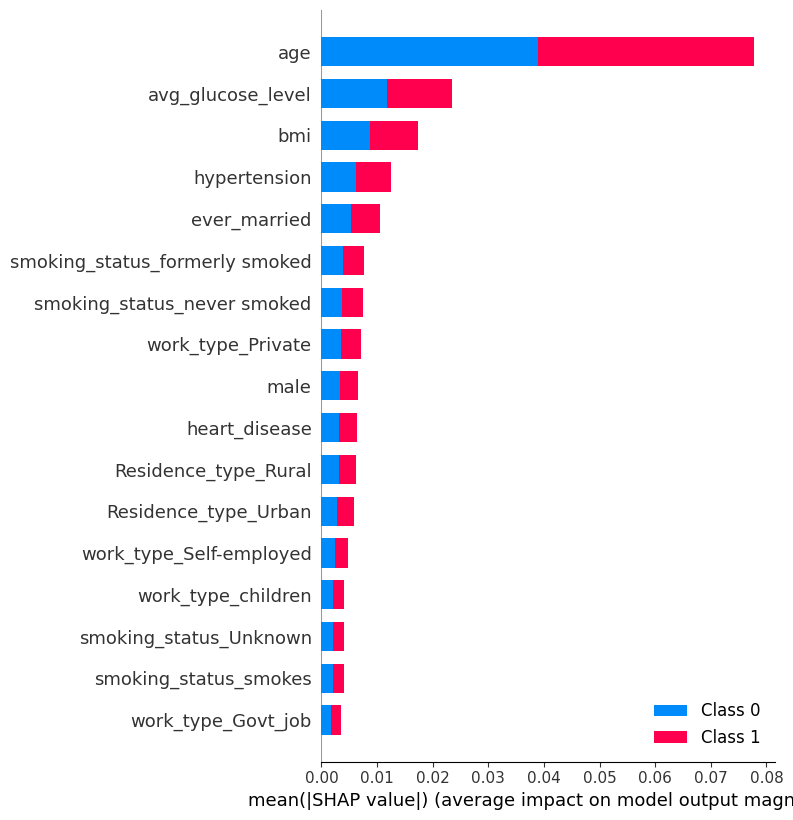

In [72]:
shap.summary_plot(shap_values, X_test, feature_names=list(X.columns))